In [55]:
!pip install spotipy pandas matplotlib>=3.4.3


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


In [1]:
import os


os.environ["SPOTIPY_CLIENT_ID"] = ""
os.environ["SPOTIPY_CLIENT_SECRET"] = ""

In [2]:
from typing import List
import pandas as pd
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy

class DataFetcher:
    
    def __init__(self):
        self.client_credentials_manager = SpotifyClientCredentials()
        self.sp = spotipy.Spotify(client_credentials_manager=self.client_credentials_manager)
    
    def get_track_ids_for_playlist(self, pl_id: str) -> List[str]:
        res = []
        offset = 0
        while True:
            response = self.sp.playlist_items(pl_id, offset=offset,
                                              fields='items.track.id,total',
                                              additional_types=['track'])
            if len(response['items']) == 0:
                break
            res.extend([track["track"]["id"] for track in response['items']])
            offset = offset + len(response['items'])
            
        return res
    
    def get_track_features(self, track_ids: List[str]) -> pd.DataFrame:
        track_features = []
        for track_id in track_ids:
            result_dct = self.sp.audio_features(track_id)[0]
            track_infos = self.sp.tracks([track_id])
            artist_name = track_infos["tracks"][0]["artists"][0]['name']
            tracks_name = track_infos["tracks"][0]["name"]
            result_dct["artist_name"] = artist_name
            result_dct["track_name"] = tracks_name
            result_dct["track_id"] = track_id
            track_features.append(result_dct)
            
        return pd.DataFrame(track_features)
    
    def fetch_data(self, pl_id: str):
        track_ids = self.get_track_ids_for_playlist(pl_id)
        track_features = self.get_track_features(track_ids)
        
        return track_features

In [42]:
from abc import abstractmethod
import numpy as np

class TrackSorter:
    
    feats = ['acousticness', 'tempo', 'energy']
    
    @abstractmethod
    def extract_relevant_columns(df: pd.DataFrame) -> pd.DataFrame:
        return df[['artist_name', 'track_name', 'track_id',
                   "danceability", "energy", "key", "loudness", "mode",
                   "speechiness", "acousticness", "instrumentalness",
                   "liveness", "valence", "tempo"]].copy()
    
    @abstractmethod
    def normalize(df: pd.DataFrame) -> pd.DataFrame:
        result = df.copy()
        for feature_name in TrackSorter.feats:
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
        return result
    
    @abstractmethod
    def order_by_features(df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df["order"] = np.nan
        df["distance"] = np.nan
        df.loc[0, "order"] = 0

        while len(df[df.order.isna()]):
            current_track_index = df.order.argmax()
            current_track = df.iloc[current_track_index]
            potential_next_tracks = df[df.order.isna()]

            a = np.array(current_track[TrackSorter.feats])
            min_dist, current_next = np.inf, np.inf
            if len(potential_next_tracks):
                for i, row in potential_next_tracks.iterrows():
                    b = np.array(row[TrackSorter.feats])
                    dist = np.linalg.norm(a - b)
                    if dist < min_dist:
                        min_dist = dist
                        current_next = i

                df.loc[current_next, "order"] = df.loc[current_track_index, "order"] + 1
                df.loc[current_next, "distance"] = min_dist

        df = df.sort_values("order").reset_index(drop=True)
        return df
    

In [54]:
import matplotlib.pyplot as plt


class OrderPlotter:
    
    @abstractmethod
    def plot_order(feature_df: pd.DataFrame):
        fig = plt.figure(figsize=(12, 12))
        ax = fig.add_subplot(projection='3d')

        x, y, z = feature_df[TrackSorter.feats[0]], feature_df[TrackSorter.feats[1]], feature_df[TrackSorter.feats[2]]

        ax.plot(x, y, z, alpha=.5, ls="--")
        ax.scatter(x, y, z)

        ax.set_xlabel(TrackSorter.feats[0])
        ax.set_ylabel(TrackSorter.feats[1])
        ax.set_zlabel(TrackSorter.feats[2])
        
        for i, txt in enumerate(feature_df.track_name):
            if txt == "Take My Hand":
                ax.text(x[i] + .015, y[i] - .015, z[i] - .035, txt, c="black", alpha=1)
            elif i % 2 == 0:
                ax.text(x[i] + .015, y[i] + .015, z[i] + .015, txt, c="black", alpha=1)
            else:
                ax.text(x[i] - .015, y[i] - .015, z[i] - .015, txt, c="black", alpha=1)

        plt.show()

In [32]:
data_fetcher = DataFetcher()

In [33]:
pl_id = 'spotify:playlist:2lEW5PR76Nxru0Ycc9SK4C'

track_features_df = data_fetcher.fetch_data(pl_id)

In [43]:
tracks_ordered = (
    track_features_df
     .pipe(TrackSorter.extract_relevant_columns)
     .pipe(TrackSorter.normalize)
     .pipe(TrackSorter.order_by_features)
)

In [44]:
tracks_ordered

,artist_name,track_name,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,order,distance
0,Kylie Minogue,Where the Wild Roses Grow,28lQMRZpJmEzCyVMMNTu4H,0.393,0.000000,5,-16.056,1,0.0481,1.000000,0.006220,0.1250,0.215,0.192647,0.0,NaN
1,Colter Wall,The Devil Wears a Suit and Tie,7hlA8gMMz6jSp91Twsnuv3,0.625,0.109875,6,-12.119,0,0.0805,0.872611,0.104000,0.0921,0.438,0.570613,1.0,0.413713
2,Jeangu Macrooy,Tell Me Father,2WoQTDLEfONjOStQXTyrvI,0.694,0.578581,8,-7.127,0,0.0499,0.538078,0.000004,0.1410,0.791,0.519699,2.0,0.578092
3,Michael Kiwanuka,Cold Little Heart - Radio Edit,7KX65PC1UZuImsUInThbav,0.629,0.472879,7,-6.208,0,0.0278,0.392966,0.000353,0.4360,0.655,0.336106,3.0,0.256782
4,George Ezra,Don't Matter Now - Acoustic Version,6D1RVzXY3lv11b7bNeivkL,0.784,0.350487,4,-9.127,0,0.0719,0.464968,0.000000,0.3580,0.641,0.132466,4.0,0.248261
5,little hurricane,Bad Business,6GB1ZoVI4x0njIOVHi7bvO,0.640,0.413074,5,-7.400,1,0.0383,0.050457,0.000014,0.3540,0.585,0.000000,5.0,0.439641
6,Middlemist Red,Blue Moon,3IoDhY5CGZQOo1WplUhOPj,0.607,0.823366,1,-5.005,0,0.0476,0.020659,0.035100,0.1770,0.166,0.198812,6.0,0.456896
7,Arctic Monkeys,I Bet You Look Good On The Dancefloor,3DQVgcqaP3iSMbaKsd57l5,0.535,0.984701,6,-4.190,0,0.0356,0.000000,0.000000,0.3760,0.778,0.241407,7.0,0.168137
8,The Kooks,Bad Habit,3huV7eiNpaQlCB3LbZi9bB,0.733,0.892907,0,-4.199,0,0.0389,0.054002,0.000010,0.1310,0.854,0.507382,8.0,0.286505
9,The Black Keys,Gold on the Ceiling,5lN1EH25gdiqT1SFALMAq1,0.505,0.824757,0,-4.632,1,0.0475,0.006059,0.000079,0.0690,0.565,0.601666,9.0,0.125827


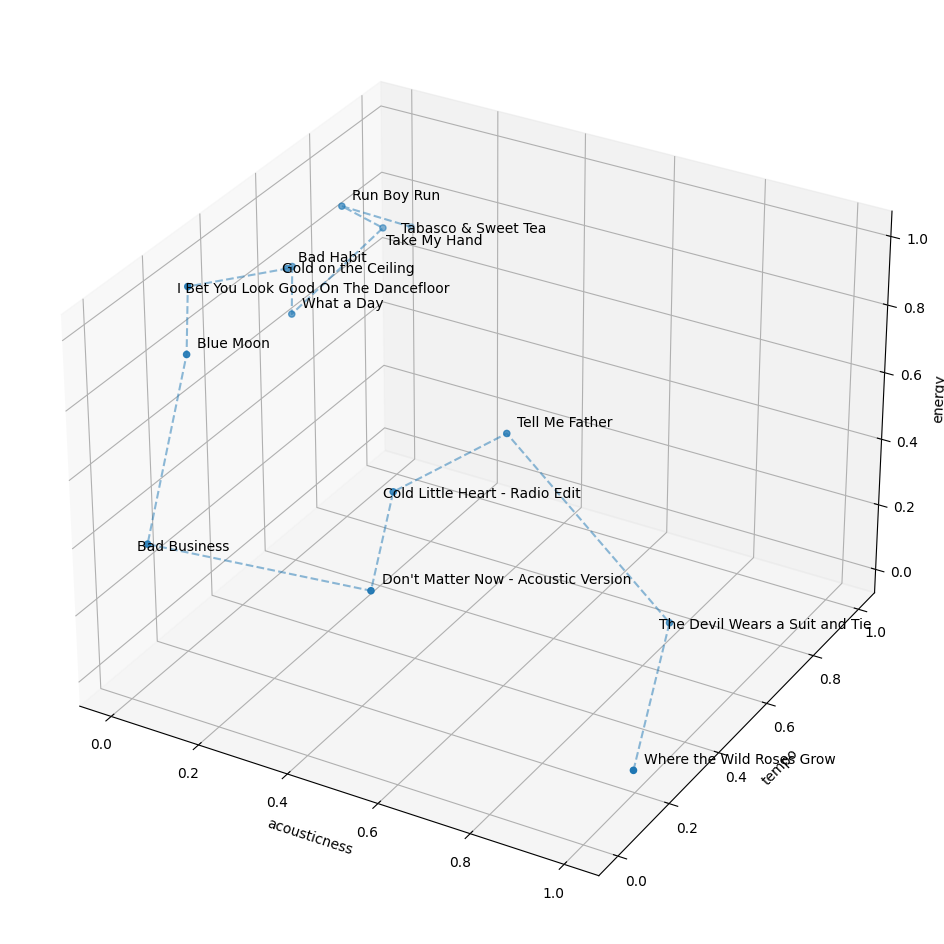

In [55]:
OrderPlotter.plot_order(tracks_ordered)

In [13]:
from spotipy.oauth2 import SpotifyOAuth

In [15]:
scope = "playlist-modify-public"

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope, redirect_uri="http://localhost:8880/callback"))
user_id = sp.me()['id']

In [24]:
playlist_name = sp.playlist(pl_id)["name"]

playlist_created_response = sp.user_playlist_create(user_id, f"{playlist_name} - sorted")

In [30]:
 sp.playlist_add_items(playlist_created_response["id"], tracks_ordered.track_id.tolist())

{'snapshot_id': 'Miw4YmFmNGJiOTIxYzYyZDBjZWRiODBkZmEzMGVlYTU4ZDk5OGQzZGU1'}